# HeartPredict

HeartPredict is a Python library designed to analyze
and predict heart failure outcomes using patient data.

## Dataset information

The dataset used for this analysis was obtained from kaggle.com.
It contains 5000 medical records of patients who had heart-failure
and is licensed under CC0; made available under [this URL](https://www.kaggle.com/datasets/aadarshvelu/heart-failure-prediction-clinical-records).


In [18]:
from heartpredict.backend.data import ProjectData, MLData, FeatureData
from heartpredict.backend.descriptive import (
    DescriptiveBackend,
    save_distribution_plot,
    show_plot,
)
from heartpredict.backend.ml import MLBackend, PretrainedModel
from heartpredict.backend.survival import SurvivalBackend
from heartpredict.backend.correlation import CorrelationBackend

from pathlib import Path
import seaborn

In [19]:
seed = 42
path_to_data = "../data/heart_failure_clinical_records.csv"
project_data = ProjectData(Path(path_to_data))
ml_data = MLData(project_data, 0.2, seed)
descriptive_data = DescriptiveBackend(path_to_data)

AttributeError: 'str' object has no attribute 'df'

### Descriptive Analysis

- What are the basic statistics (mean, median, standard deviation)
  of the clinical features?
- How is the age distribution of patients?
- What is the proportion of patients with conditions like anaemia, diabetes
  and high blood pressure?

In [ ]:
# Calculate exemplary discrete and boolean stats
discrete_column = "creatinine_phosphokinase"
boolean_column = "smoking"

boolean_stat = descriptive_data.calculate_boolean_statistics(boolean_column)
discrete_stat = descriptive_data.calculate_discrete_statistics(discrete_column)

print(boolean_stat)
print(discrete_stat)

In [ ]:
# Find out how many patients are over 60
over_60 = descriptive_data.create_conditional_dataset(col="age", num=60, rel=">")

print(f"{len(over_60)} of {len(descriptive_data.df)} patients are over 60")

In [ ]:
# How is the age distribution?
col = "age"
age_distribution = descriptive_data.save_variable_distribution(col)
age_plot = save_distribution_plot(age_distribution, col)
show_plot(age_plot)

In [ ]:
# How many patients have high blood pressure?
col = "high_blood_pressure"
age_distribution = descriptive_data.save_variable_distribution(col)
age_plot = save_distribution_plot(age_distribution, col)
show_plot(age_plot)

### Correlation and Feature Importance

- Which clinical features are most strongly correlated with the DEATH_EVENT?
  And what are the most important features for predicting heart failure outcomes?
- How do different clinical features contribute
  to the risk of death due to heart failure?

In [ ]:
from heartpredict.backend.correlation import CorrelationMethod


correlation_backend = CorrelationBackend.build(project_data)
matrix = correlation_backend.get_correlation_matrix(CorrelationMethod.PEARSON)
seaborn.heatmap(
    matrix, fmt=".1f", annot=True, cmap=seaborn.cubehelix_palette(as_cmap=True)
)

### Predictive Analysis

- How accurately can we predict DEATH_EVENT using clinical features?
- Which machine learning model performs best for this prediction task?

We used the scikit-learn library to train different classifier models.
Therefore, we split the dataset into training / test set (80%) and a validation set (20%).
For every model, we search for the best value of a tunable hyperparameter using k-fold cross-validation on the training / test set.
We choose the best value for the hyperparameter based on the mean accuracy of the cross-validation folds.
After that the model is trained on the entire training / test set and evaluated on the validation set.
In the following table, we summarize the results of the different models, where the accuracy is the accuracy on the validation set:

| Model                          | Accuracy | Hyperparameter      | Best Hyperparameter Value |
|--------------------------------|----------|---------------------|---------------------------|
| Decision Tree Classifier       | 0.859    | Max Depth           | 5                         |
| Random Forest Classifier       | 0.992    | Max Depth           | 5                         |
| K-Nearest Neighbors Classifier | 0.977    | Number of Neighbors | 3                         |
| Linear Discriminant Analysis   | 0.839    | -                   | -                         |
| Quadratic Discriminant Analysis| 0.829    | -                   | -                         |

The Random Forest Classifier achieved the highest accuracy of 0.992, when setting the maximum depth of the tree to 5.

The following code snippet shows the classification results for the different models:

In [ ]:
ml_backend = MLBackend(ml_data)
ml_backend.classification_for_different_classifiers()

In the following code cell, you can try to predict the DEATH_EVENT for a given patient set (You need to modify the example_data_points.csv):

In [ ]:
# Predict DEATH_EVENT for a given patient set
pretrained_model = PretrainedModel()
pretrained_model.load_model("../results/trained_models/classifier/RandomForestClassifier_model_42.joblib")

feature_data = FeatureData(project_data(Path("../data/example_data_points.csv")), Path("../results/scalers/used_scaler.joblib"))

idx = 0
for y  in pretrained_model.predict(feature_data):
    print("Patient", idx, ":", y)
    idx += 1

### Survival Analysis

- Can we identify patient subgroups with higher or lower survival probabilities? 
- And what is the survival rate of patients over the follow-up period?

We can use Kaplan-Meier survival curves to visualize the survival probabilities of patients with different clinical features.
This will help us understand how different risk factors affect patient outcomes.

Therefore, we used a regression model to predict the survival probability of the patients.
Then we assign the patients to high-risk, medium-risk and low-risk groups based on their predicted survival probabilities.
For each group, we generate a Kaplan-Meier survival curve to visualize the survival probabilities over time.

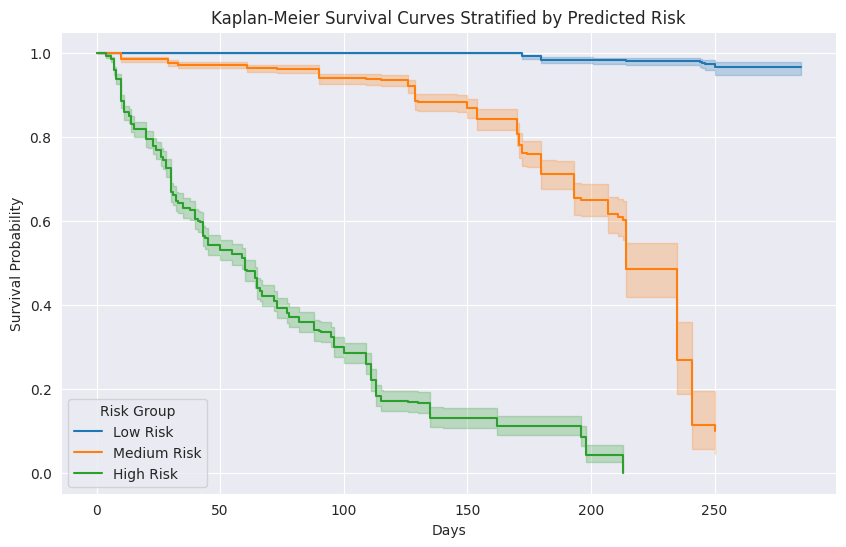

In [20]:
regressor = "../results/trained_models/regressor/LogisticRegression_model_42.joblib"

survival_backend = SurvivalBackend(ml_data)
survival_backend.create_kaplan_meier_plot_for(Path(regressor), show_plot=True)

### Risk Factor Analysis

- How does smoking affect the risk of death in heart failure patients?
- What is the impact of serum creatinine and serum sodium levels on patient outcomes?
- How does the combination of multiple risk factors affect the likelihood
  of heart failure-related death?